# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import  roc_curve, roc_auc_score
import time

import ray
from ray.util.joblib import register_ray
import joblib
import pickle
# import mlflow
# from mlflow.models import infer_signature

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")

In [3]:
# Check duplicates
df.duplicated().sum()

np.int64(719)

In [4]:
# Drop duplicates
df.drop_duplicates(inplace=True)

<Axes: xlabel='booking_complete', ylabel='count'>

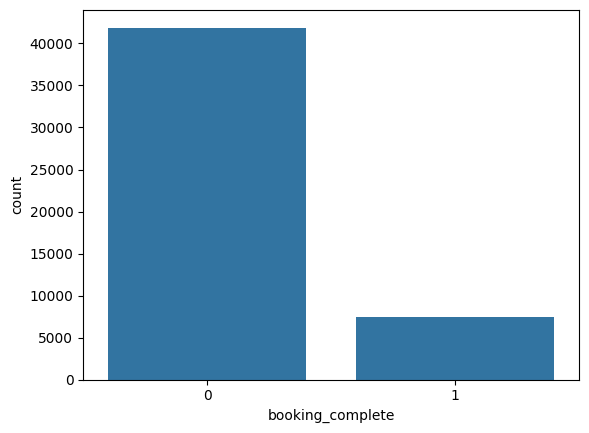

In [5]:
sns.countplot(data=df, x='booking_complete')

In [6]:
# data and label
data = df.copy()

In [7]:
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    data[col] = le.fit_transform(data[col])

In [8]:
X = data.drop('booking_complete', axis=1)
y = data['booking_complete']

In [9]:
y.value_counts()

booking_complete
0    41890
1     7391
Name: count, dtype: int64

In [10]:
undersample = RandomUnderSampler(random_state=0, sampling_strategy='majority', replacement=True)
X, y  = undersample.fit_resample(X, y)

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
data_scaled = pd.DataFrame(X_scaled, columns=X.columns)

**Note**
Because the data is imbalanced:
1. Use Cross Validation to split data
2. Use Random Forest For Modelling

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled , y,test_size=0.2, random_state=42)

In [13]:
X_train

array([[-0.58971927, -0.3281475 ,  0.08366635, ..., -0.6796853 ,
         1.12615344, -0.08050891],
       [-0.58971927,  3.04741012,  0.08366635, ...,  1.47126913,
        -0.88797846,  1.12468815],
       [ 1.34100724, -0.3281475 ,  0.08366635, ..., -0.6796853 ,
         1.12615344,  1.12468815],
       ...,
       [-0.58971927, -0.3281475 ,  0.08366635, ..., -0.6796853 ,
        -0.88797846, -0.33076841],
       [ 0.37564399,  3.04741012,  0.08366635, ..., -0.6796853 ,
        -0.88797846,  1.12468815],
       [-0.58971927, -0.3281475 ,  0.08366635, ..., -0.6796853 ,
        -0.88797846,  1.12468815]])

# Modeling

In [14]:
# EXPERIMENT_NAME = "Airways-Booking-Completion-Prediction"
# # EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)

# current_experiment=dict(mlflow.get_experiment_by_name(EXPERIMENT_NAME))
# experiment_id=current_experiment['experiment_id']
params={
    'n_estimators': 250,
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt'
}


In [15]:
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
kf = StratifiedKFold(n_splits=5)

In [16]:
rf = RandomForestClassifier(**params)

In [17]:
scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='precision')  # a list of error terms
cv_score = np.mean(scores)

In [18]:
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=250)

In [19]:
# ray.init(ignore_reinit_error=True)
# def track_resources()->None:
#     resources = ray.available_resources()
# def predict():
#     params={
#         'n_estimators': [100, 250, 500],    
#         'criterion': ['gini', 'entropy'],
#         'max_depth': [None, 10, 20, 30],    
#         'max_features': ['auto', 'sqrt', 'log2'], 
#     }

#     model_search = RandomizedSearchCV(rf, params, cv=5, n_iter=300, verbose=10)
#     # register_ray()
    
#     # try:
#     #     print('Randomized...')
#     #     with joblib.parallel_backend('ray'):
#     model_search.fit(X_train, y_train)
#     print('Best Parameter', model_search.best_params_)
#     # except Exception as e:
#     #     print(e)

# if __name__ == "__main__":
#     start = time.time()
#     # track_resources()
#     print('Running...')
#     predict()
#     # track_resources()
#     end = time.time()

#     print('Estimasi waktu', end - start)

    
# scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='precision')  # a list of error terms
# cv_score = np.mean(scores)

In [20]:
rf.feature_importances_

array([0.0455367 , 0.01426223, 0.00288801, 0.17016052, 0.12827178,
       0.12923736, 0.08583105, 0.15684754, 0.13125596, 0.01838683,
       0.01835959, 0.0224452 , 0.07651724])

In [21]:
y_pred_rf = rf.predict_proba(X_test)[:,1]
auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f"AUC-ROC for Random Forest: {auc_rf}")
y_pred = rf.predict(X_test)

AUC-ROC for Random Forest: 0.7867037411526794


In [22]:
y_pred.shape

(2957,)

In [23]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, accuracy

(np.float64(0.7026143790849673),
 np.float64(0.7352941176470589),
 np.float64(0.7185828877005348),
 0.7152519445383835)

In [24]:
matrix_confusion = confusion_matrix(y_test, y_pred)
# sns.heatmap(matrix_confusion, square=True, annot=True, fmt='d')
matrix_confusion

array([[1040,  455],
       [ 387, 1075]])

In [25]:
def plot_roc_curves(y_test, y_pred):
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
        # Plot random classifier
    plt.plot([0,1],[0,1], linestyle='--', label='Random Classifier')
    plt.fill_between(fpr_rf, tpr_rf, color='#B9ECFF')

    # Format the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for British Airways Booking Completion')
    plt.legend()
    plt.show()

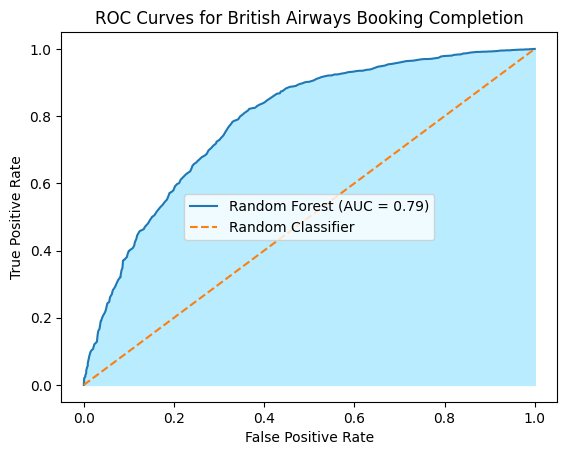

In [26]:
plot_roc_curves(y_test, y_pred_rf)

In [27]:
# # Set our tracking server uri for logging
# mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# # Create a new MLflow Experiment
# mlflow.set_experiment("Airways-Booking-Completion-Prediction")

# # Start an MLflow run
# with mlflow.start_run():
#     # Log the hyperparameters
#     mlflow.log_params(params)

#     # Log the loss metric
#     mlflow.log_metric("precision", accuracy)
#     mlflow.log_metric("recall", recall)
#     mlflow.log_metric("precision", precision)
#     mlflow.log_metric("f1-score", f1)
#     mlflow.log_metric("auc", auc_rf)
#     mlflow.log_metric("precision_from_cv", cv_score)

#     # Set a tag that we can use to remind ourselves what this run was for
#     mlflow.set_tag("Training Info", "RF with AUC Value")

#     # Infer the model signature
#     signature = infer_signature(X_train, rf.predict(X_train))

#     # Log the model
#     model_info = mlflow.sklearn.log_model(
#         sk_model=rf,
#         artifact_path="airways_model",
#         signature=signature,
#         input_example=X_train,
#         registered_model_name="tracking-quickstart",
#     )

In [28]:
# with open("model.pkl", "rb") as file:
#     model = pickle.load(file)

In [29]:
# data_feature = {'Feature':X.columns,
#         'Importance':model.feature_importances_}

In [30]:
# feature_contribution = pd.DataFrame(data_feature)

In [31]:
# feature_contribution.sort_values(by='Importance', ascending=True, inplace=True)

In [32]:
# feature_contribution.plot(x='Feature', y='Importance', rot=0, kind='barh')

# Modelling (5 Features only)

In [33]:
new_data = data_scaled[['purchase_lead', 'route', 'booking_origin', 'flight_hour', 'length_of_stay']]
new_data

,purchase_lead,route,booking_origin,flight_hour,length_of_stay
0,0.426756,-1.296504,-1.233950,0.359728,-0.029397
1,-0.132797,1.513079,-1.233950,-1.324030,1.770870
2,-0.692349,-1.447095,-0.817326,1.108064,-0.486608
3,0.773678,-0.384358,1.361938,1.295149,-0.486608
4,-0.043268,1.452843,-1.233950,2.417654,2.599564
...,...,...,...,...,...
14777,-0.546865,1.409817,1.554226,-0.575693,-0.458032
14778,-0.748304,1.409817,0.272306,1.295149,-0.458032
14779,1.792064,1.418422,0.272306,-0.014441,-0.458032
14780,-0.837833,1.422725,-1.233950,-0.949862,-0.458032


In [34]:
X_train, X_test, y_train, y_test = train_test_split(new_data , y,test_size=0.2, random_state=42)

# Modeling

In [35]:
scores = cross_val_score(rf, X_train, y_train, cv=kf, scoring='precision')  # a list of error terms
cv_score = np.mean(scores)

In [36]:
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=250)

In [37]:
rf.feature_importances_

array([0.2783612 , 0.23786103, 0.14885006, 0.17433791, 0.1605898 ])

In [38]:
y_pred_rf = rf.predict_proba(X_test)[:,1]
auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f"AUC-ROC for Random Forest: {auc_rf}")
y_pred = rf.predict(X_test)

AUC-ROC for Random Forest: 0.7673421207948062


In [39]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, accuracy

(np.float64(0.6985743380855397),
 np.float64(0.7038303693570451),
 np.float64(0.7011925042589437),
 0.7034156239431857)

In [40]:
matrix_confusion = confusion_matrix(y_test, y_pred)
# sns.heatmap(matrix_confusion, square=True, annot=True, fmt='d')
matrix_confusion

array([[1051,  444],
       [ 433, 1029]])

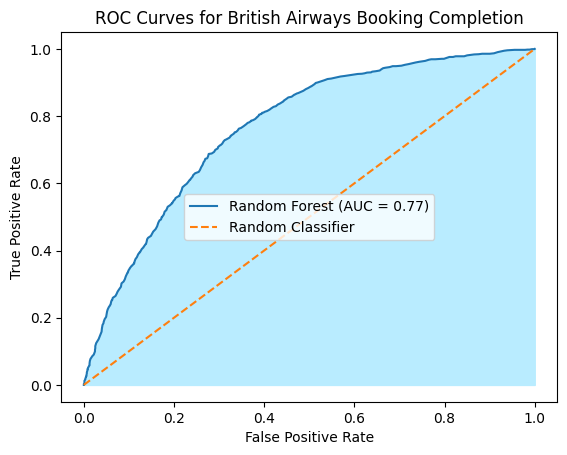

In [41]:
plot_roc_curves(y_test, y_pred_rf)